In [1]:
from preprocess.preprocess import *
import PARAMETERS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'DRIVE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu,get_pyramid_dataset,lanczos,False,5,True,True


### Resultado CV

F1-score 0.685426

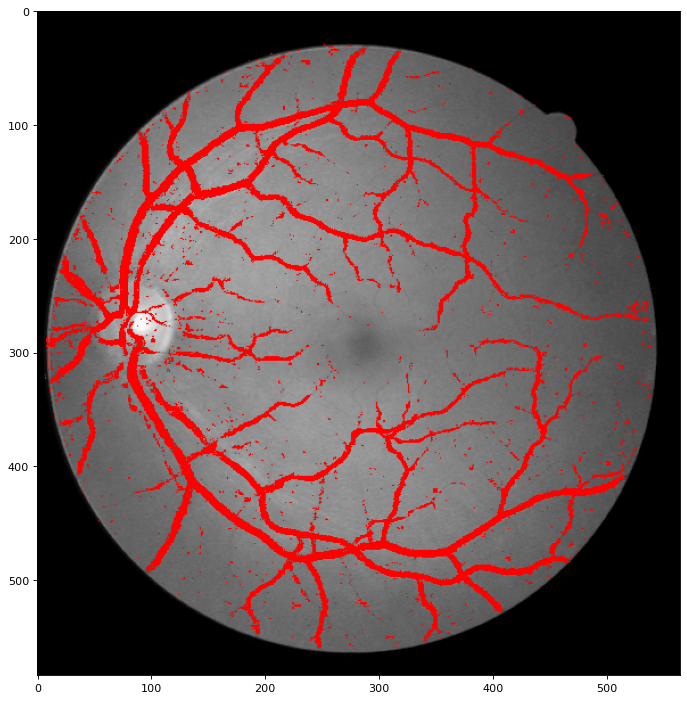

Accuracy score: 0.9292555186111174

F1 score: 0.7211952246541113

Confusion matrix:

     t/p      0     1 
        0 1141617 45928 
        1 50476 124686 
Sensivity: 0.7118324750802114
Specificity: 0.9613252550429668


(0.929, 0.721, 1141617, 45928, 50476, 124686)

In [5]:
from main import main
PARAMETERS.PLOT = True

main(lgb='Num', all_lbp=['riu', 'var'], plot_once=True, channels=(1, 2), recurrence=False)

In [8]:
import pickle

path = 'convolution/outputs/16477813803335671'
with open(f'{path}/population.pkl', 'rb') as handle:
    kernels = pickle.load(handle)

In [19]:
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
#k1, k2 = population[np.argmax(fitness), :9], population[np.argmax(fitness), 9:]

In [27]:
from os import listdir

PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/images'
MASK_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/mask'
LABELS_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/1st_manual'
n_kernels = 2
k_len = 9
k_size = 3

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:14]
    return [Preprocess.img_processing(np.asarray(Image.open(path).convert('RGB'))[:, :, 1])
            for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:14]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

conv_features = [pd.DataFrame(np.array(
    [cv2.filter2D(img, -1, individual[i*k_len:(i+1)*k_len].reshape((k_size, k_size)))[mask]
     for i in range(n_kernels)]
).T)
    for img, mask in zip(IMAGES, MASKS)]

conv_features = pd.concat(conv_features, axis=0)
conv_features.columns = ['k1', 'k2']
conv_features

,k1,k2
0,48,7
1,53,7
2,57,6
3,39,23
4,35,26
...,...,...
226537,96,100
226538,104,96
226539,88,101
226540,85,70


In [15]:
import pandas as pd
import numpy as np

preprocess = Preprocess(height=608, width=576)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])
    
cv_folds

{0: (0, 681473),
 1: (681473, 1361653),
 2: (1361653, 2044115),
 3: (2044115, 2724019),
 4: (2724019, 3178299)}

In [30]:
from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def test_features(features, verbose=False):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        PARAMETERS.MODEL_NAME = f"_cv_feat_sel_{k}"
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(
            df_train_temp, y_train_temp.values.ravel(), lgb='Num', parent_path='../models')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}

In [28]:
from main import get_channel_features, get_labels
import pandas as pd

df_train, _ = get_channel_features('../', lbp_version=['riu', 'var'], channels=(1, 2))
y_train, _ = get_labels('../')

df_train = pd.concat([df_train, conv_features], axis=1)

features = {'x_train': df_train, 'x_test': None, 'y_train': y_train, 'y_test': None}

In [32]:
test_features(features, verbose=True)

Accuracy score: 0.939150927476217

F1 score: 0.7136355788819446

Confusion matrix:

     t/p      0     1 
        0 588337 16972 
        1 24495 51669 
Sensivity: 0.6783913659996849
Specificity: 0.9719614279648907
-------------------------------------
Accuracy score: 0.9200123496721456

F1 score: 0.6614647501711157

Confusion matrix:

     t/p      0     1 
        0 572622 10183 
        1 44223 53152 
Sensivity: 0.5458485237483954
Specificity: 0.9825276035723784
-------------------------------------
Accuracy score: 0.933887894124508

F1 score: 0.7325378053624039

Confusion matrix:

     t/p      0     1 
        0 575556 17888 
        1 27231 61787 
Sensivity: 0.6940955761756049
Specificity: 0.9698573075134301
-------------------------------------
Accuracy score: 0.9382559890808114

F1 score: 0.6807847311991484

Confusion matrix:

     t/p      0     1 
        0 593159 14015 
        1 27965 44765 
Sensivity: 0.6154956689124158
Specificity: 0.976917654576777
---------------------

{'acc': 0.9266519401274416, 'f1': 0.6851144526370688}

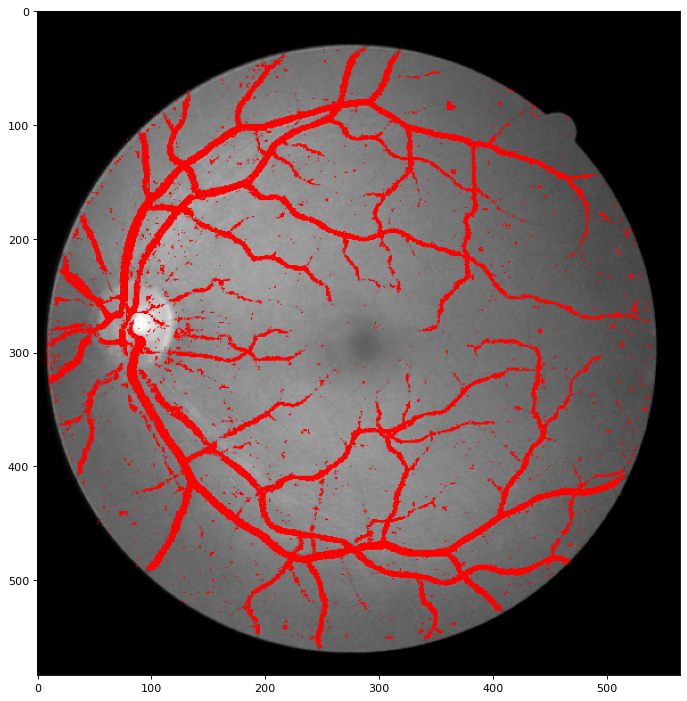

Accuracy score: 0.9293751334659615

F1 score: 0.7214467023441186

Confusion matrix:

     t/p      0     1 
        0 1141835 45710 
        1 50531 124631 
Sensivity: 0.7115184800356241
Specificity: 0.9615088270339229


(0.929, 0.721, 1141835, 45710, 50531, 124631)

In [33]:
def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][14:]
    return [Preprocess.img_processing(np.asarray(Image.open(path).convert('RGB'))[:, :, 1])
            for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][14:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images()
MASKS_test = load_masks()

conv_features_test = [pd.DataFrame(np.array(
    [cv2.filter2D(img, -1, individual[i*k_len:(i+1)*k_len].reshape((k_size, k_size)))[mask]
     for i in range(n_kernels)]
).T)
    for img, mask in zip(IMAGES_test, MASKS_test)]

conv_features_test = pd.concat(conv_features_test, axis=0)
conv_features_test.columns = ['k1', 'k2']

extra_features = {'train': conv_features, 'test': conv_features_test}
main(lgb='Num', all_lbp=['riu', 'var'], extra_features=extra_features, plot_once=True, channels=(1, 2), recurrence=False)